<a href="https://colab.research.google.com/github/anjalii-s/Thesis-2026-/blob/main/Thesis_experiment_German_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup & Imports

In [3]:
# Install required packages if not already available
!pip install imbalanced-learn shap lightgbm xgboost seaborn

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import shap

plt.style.use('default')
sns.set_palette("husl")
np.random.seed(42)


Load & Preprocess Dataset

In [4]:
# Load German Credit dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
cols = ['checking_status','duration','credit_history','purpose','credit_amount',
        'savings_status','employment','installment_commitment','personal_status',
        'other_parties','residence_since','property_magnitude','age',
        'other_payment_plans','housing','existing_credits','job',
        'num_dependents','own_telephone','foreign_worker','target']

df = pd.read_csv(url, sep=' ', header=None, names=cols)
df['target'] = df['target'].map({1:0, 2:1})  # 1=good(0), 2=bad(1)

X = df.drop('target', axis=1)
y = df['target']

# Preprocessor: OneHot for categorical, StandardScaler for numeric
cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(include='number').columns

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
    ('num', StandardScaler(), num_cols)
])
preprocessor.fit(X)


ColumnTransformer(transformers=[('cat',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 Index(['checking_status', 'credit_history', 'purpose', 'savings_status',
       'employment', 'personal_status', 'other_parties', 'property_magnitude',
       'other_payment_plans', 'housing', 'job', 'own_telephone',
       'foreign_worker'],
      dtype='object')),
                                ('num', StandardScaler(),
                                 Index(['duration', 'credit_amount', 'installment_commitment',
       'residence_since', 'age', 'existing_credits', 'num_dependents'],
      dtype='object'))])

Define Models & Samplers

In [5]:
# Imbalance handling methods
resamplers = {
    'None': None,
    'SMOTE': SMOTE(random_state=42),
    'Borderline': BorderlineSMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'SMOTEENN': SMOTEENN(random_state=42),
    'SMOTETomek': SMOTETomek(random_state=42),
    'Under': RandomUnderSampler(random_state=42),
    'CostSensitive': 'cost'
}

# Class weights for cost-sensitive
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weight_dict = {cls: w for cls, w in zip(classes, weights)}

# Models
models = {
    'RF': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'XGB': xgb.XGBClassifier(n_estimators=100, max_depth=6, random_state=42,
                             eval_metric='logloss', base_score=0.5),
    'LGB': lgb.LGBMClassifier(n_estimators=100, max_depth=6, random_state=42, verbose=-1)
}


Train Models

In [6]:
seeds = [42,123,456]
results = []

for run, seed in enumerate(seeds,1):
    X_tr, X_te, y_tr, y_te = train_test_split(X,y,test_size=0.25,stratify=y,random_state=seed)
    for mname, model in models.items():
        for sname, sampler in resamplers.items():
            steps = [('prep', preprocessor)]
            if sampler and sampler!='cost': steps.append(('samp', sampler))
            steps.append(('clf', model))
            pipe = ImbPipeline(steps)

            # Apply cost-sensitive weights
            if sname == 'CostSensitive':
                if mname == 'RF':
                    pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)
                elif mname == 'XGB':
                    ratio = class_weight_dict[1]/class_weight_dict[0]
                    pipe.named_steps['clf'].set_params(scale_pos_weight=ratio)
                elif mname == 'LGB':
                    pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)

            pipe.fit(X_tr,y_tr)
            auc = roc_auc_score(y_te, pipe.predict_proba(X_te)[:,1])
            results.append({'run':run,'model':mname,'sampler':sname,'auc':auc,'pipe':pipe,'X_test':X_te})
            print(f"{mname}+{sname:12} → AUC: {auc:.4f}")

results_df = pd.DataFrame(results)


RF+None         → AUC: 0.7701
RF+SMOTE        → AUC: 0.7781
RF+Borderline   → AUC: 0.7880
RF+ADASYN       → AUC: 0.7878
RF+SMOTEENN     → AUC: 0.7799
RF+SMOTETomek   → AUC: 0.8011
RF+Under        → AUC: 0.8117
RF+CostSensitive → AUC: 0.8076
XGB+None         → AUC: 0.8031
XGB+SMOTE        → AUC: 0.8045
XGB+Borderline   → AUC: 0.8050
XGB+ADASYN       → AUC: 0.8056
XGB+SMOTEENN     → AUC: 0.7726
XGB+SMOTETomek   → AUC: 0.7947
XGB+Under        → AUC: 0.7801
XGB+CostSensitive → AUC: 0.8333
LGB+None         → AUC: 0.8153
LGB+SMOTE        → AUC: 0.8035
LGB+Borderline   → AUC: 0.7966
LGB+ADASYN       → AUC: 0.8005
LGB+SMOTEENN     → AUC: 0.7782
LGB+SMOTETomek   → AUC: 0.7973
LGB+Under        → AUC: 0.7738
LGB+CostSensitive → AUC: 0.8049
RF+None         → AUC: 0.7799
RF+SMOTE        → AUC: 0.7941
RF+Borderline   → AUC: 0.7965
RF+ADASYN       → AUC: 0.7964
RF+SMOTEENN     → AUC: 0.7778
RF+SMOTETomek   → AUC: 0.7919
RF+Under        → AUC: 0.7623
RF+CostSensitive → AUC: 0.7799
XGB+None         → A

explanation Methods

In [7]:
def get_shap_reliable(pipe,X_test):
    clf = pipe.named_steps['clf']
    X_proc = pipe.named_steps['prep'].transform(X_test)
    try:
        explainer = shap.TreeExplainer(clf)
        sv = explainer.shap_values(X_proc)
        return sv[1] if isinstance(sv,list) else sv
    except:
        from sklearn.inspection import permutation_importance
        result = permutation_importance(clf,X_proc,pipe.predict(X_proc),n_repeats=3,random_state=42)
        importance_scores = result.importances_mean
        return np.tile(importance_scores,(X_proc.shape[0],1))

def compute_banzhaf(pipe,X_test,n_samples=5,max_instances=5):
    clf = pipe.named_steps['clf']
    X_proc = pipe.named_steps['prep'].transform(X_test)
    n_features = X_proc.shape[1]
    n_instances = min(max_instances,X_proc.shape[0])
    banzhaf_matrix = np.zeros((n_instances,n_features))
    for i in range(n_instances):
        x_instance = X_proc[i:i+1]
        for f in range(n_features):
            contributions = []
            for _ in range(n_samples):
                coalition = np.random.binomial(1,0.5,n_features)
                coalition[f]=0
                pred_without = clf.predict_proba(x_instance*coalition.reshape(1,-1))[0,1]
                coalition[f]=1
                pred_with = clf.predict_proba(x_instance*coalition.reshape(1,-1))[0,1]
                contributions.append(pred_with-pred_without)
            banzhaf_matrix[i,f]=np.mean(contributions)
    return banzhaf_matrix

feature_groups = {
    'Demographic':['age','personal_status','job','housing','own_telephone','foreign_worker'],
    'Financial':['checking_status','savings_status','credit_amount','property_magnitude'],
    'Credit_History':['credit_history','duration','purpose','existing_credits','installment_commitment'],
    'Other':['other_parties','other_payment_plans','residence_since','num_dependents']
}

def compute_owen(pipe,X_test,feature_groups,n_samples=3,max_instances=5):
    clf = pipe.named_steps['clf']
    prep = pipe.named_steps['prep']
    X_proc = prep.transform(X_test)
    feature_names = prep.get_feature_names_out()
    group_indices = {g:[i for i,name in enumerate(feature_names) if any(f in name for f in feats)]
                     for g,feats in feature_groups.items()}
    n_features = X_proc.shape[1]
    n_instances = min(max_instances,X_proc.shape[0])
    owen_matrix = np.zeros((n_instances,n_features))
    for i in range(n_instances):
        x_instance = X_proc[i:i+1]
        for f in range(n_features):
            contributions=[]
            for _ in range(n_samples):
                group_mask={g:np.random.choice([0,1]) for g in group_indices}
                mask=np.zeros(n_features)
                for g,idxs in group_indices.items():
                    if group_mask[g]==1:
                        if f in idxs:
                            for idx in idxs: mask[idx]=np.random.choice([0,1])
                        else: mask[idxs]=1
                mask_without=mask.copy(); mask_without[f]=0
                pred_without=clf.predict_proba(x_instance*mask_without)[0,1]
                pred_with=clf.predict_proba(x_instance*mask)[0,1]
                contributions.append(pred_with-pred_without)
            owen_matrix[i,f]=np.mean(contributions)
    return owen_matrix


Metrics Functions

In [8]:
def stability_cv(expl_list):
    if len(expl_list) < 2:
        return 1.0
    arr = np.stack([np.abs(np.array(exp)) for exp in expl_list])
    mean = arr.mean(axis=0) + 1e-8
    std = arr.std(axis=0)
    cv_per_feature = (std / mean).mean(axis=0)
    return float(np.nanmean(cv_per_feature))

def jaccard_topk(expl_list, k=5):
    if len(expl_list) < 2:
        return 0.0
    sets = []
    for exp in expl_list:
        imp = np.abs(np.array(exp)).mean(axis=0).ravel()
        topk = set(int(i) for i in np.argsort(imp)[-k:])
        sets.append(topk)
    sims = []
    for i in range(len(sets)):
        for j in range(i+1, len(sets)):
            inter = len(sets[i] & sets[j])
            union = len(sets[i] | sets[j])
            if union > 0:
                sims.append(inter/union)
    return float(np.mean(sims)) if sims else 0.0

def interpretability_score(cv, j, beta=0.5):
    return beta*(1-cv)+(1-beta)*j

def normalize(series):
    rng = series.max() - series.min()
    return (series - series.min())/(rng+1e-8)

def tradeoff_metric(auc_series, I_series, alpha=0.5):
    auc_n = normalize(auc_series)
    I_n = normalize(I_series)
    return alpha*auc_n + (1-alpha)*I_n


Collect Explanations

In [9]:
explanations_by_method = {}
print("\nComputing SHAP, BANZHAF, OWEN across all configurations...")
grouped = results_df.groupby(['model','sampler'])

for (m,s), group in grouped:
    shap_runs, banzhaf_runs, owen_runs = [], [], []
    for _, row in group.iterrows():
        pipe = row['pipe']
        X_test = row['X_test']
        X_test_sample = X_test.sample(n=50, random_state=42) if len(X_test)>50 else X_test

        shap_runs.append(get_shap_reliable(pipe, X_test_sample))
        banzhaf_runs.append(compute_banzhaf(pipe, X_test_sample))
        owen_runs.append(compute_owen(pipe, X_test_sample, feature_groups))

    explanations_by_method[(m,s,'SHAP')] = shap_runs
    explanations_by_method[(m,s,'Banzhaf')] = banzhaf_runs
    explanations_by_method[(m,s,'Owen')] = owen_runs



Computing SHAP, BANZHAF, OWEN across all configurations...


Compute Metrics per Method × Config

In [10]:
records = []
for (m,s), group in grouped:
    auc_mean = group['auc'].mean()
    for method in ['SHAP','Banzhaf','Owen']:
        expl_runs = explanations_by_method[(m,s,method)]
        cv = stability_cv(expl_runs)
        j = jaccard_topk(expl_runs)
        I = interpretability_score(cv,j)
        records.append({
            'Model':m,'Sampler':s,'Method':method,
            'AUC':auc_mean,'CV':cv,'Stability':1-cv,
            'Jaccard':j,'I':I
        })

metrics_methods = pd.DataFrame(records)
metrics_methods['T(α=0.5)'] = tradeoff_metric(metrics_methods['AUC'],metrics_methods['I'])
print("\nFINAL METHOD-LEVEL METRICS:")
print(metrics_methods.round(4).to_string(index=False))



FINAL METHOD-LEVEL METRICS:
Model       Sampler  Method    AUC     CV  Stability  Jaccard      I  T(α=0.5)
  LGB        ADASYN    SHAP 0.7870 0.4682     0.5318   1.0000 0.7659    0.9717
  LGB        ADASYN Banzhaf 0.7870 0.5412     0.4588   0.3426 0.4007    0.5522
  LGB        ADASYN    Owen 0.7870 0.4562     0.5438   0.2169 0.3804    0.5288
  LGB    Borderline    SHAP 0.7853 0.4682     0.5318   1.0000 0.7659    0.9522
  LGB    Borderline Banzhaf 0.7853 0.5336     0.4664   0.2632 0.3648    0.4915
  LGB    Borderline    Owen 0.7853 0.3946     0.6054   0.3095 0.4574    0.5979
  LGB CostSensitive    SHAP 0.7846 0.4682     0.5318   1.0000 0.7659    0.9450
  LGB CostSensitive Banzhaf 0.7846 0.5306     0.4694   0.3095 0.3895    0.5126
  LGB CostSensitive    Owen 0.7846 0.4468     0.5532   0.2037 0.3784    0.4999
  LGB          None    SHAP 0.7881 0.4682     0.5318   1.0000 0.7659    0.9831
  LGB          None Banzhaf 0.7881 0.5356     0.4644   0.2037 0.3340    0.4869
  LGB          None    

Plots

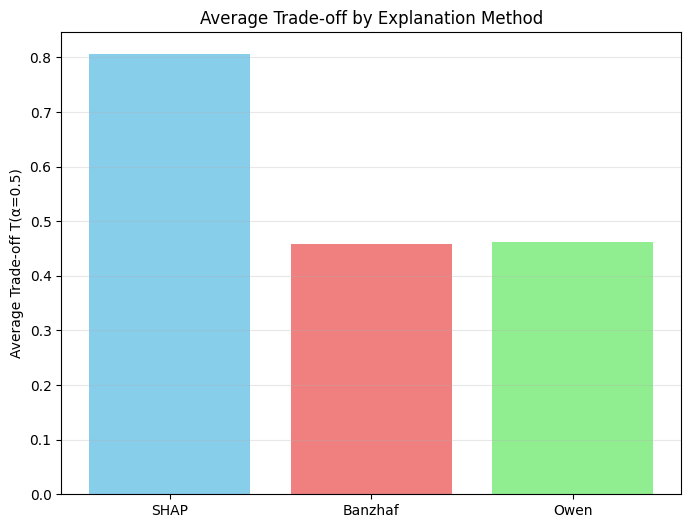

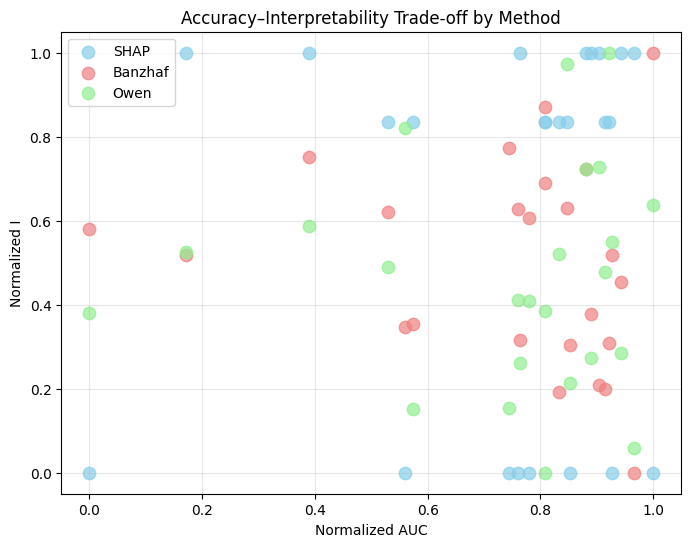

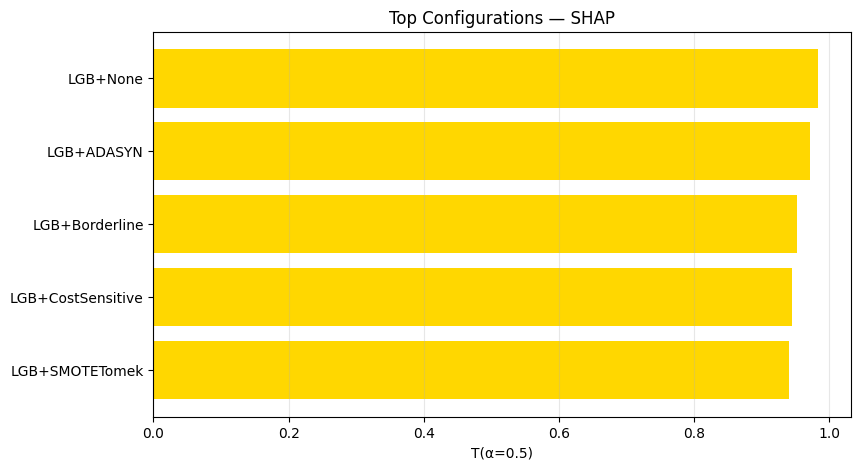

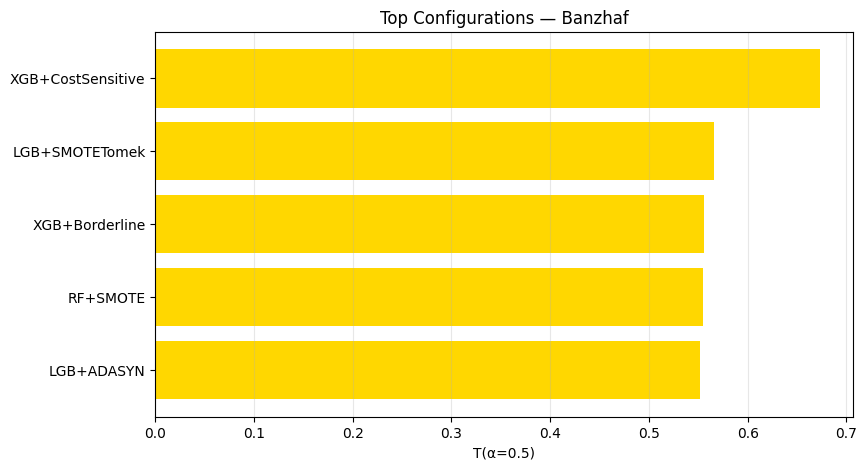

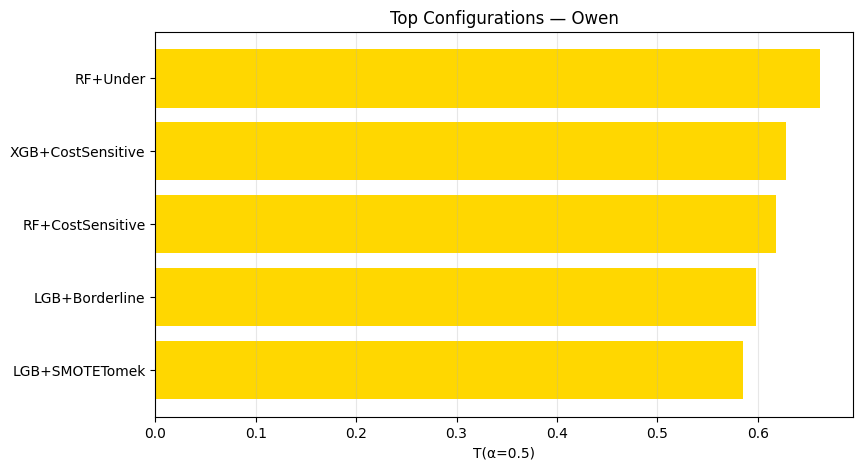

In [11]:
# Average trade-off by method
plt.figure(figsize=(8,6))
method_avg = metrics_methods.groupby('Method')['T(α=0.5)'].mean().reindex(['SHAP','Banzhaf','Owen'])
plt.bar(method_avg.index, method_avg.values, color=['skyblue','lightcoral','lightgreen'])
plt.ylabel("Average Trade-off T(α=0.5)")
plt.title("Average Trade-off by Explanation Method")
plt.grid(axis='y', alpha=0.3)
plt.show()

# Accuracy vs Interpretability scatter
plt.figure(figsize=(8,6))
for method,color in zip(['SHAP','Banzhaf','Owen'],['skyblue','lightcoral','lightgreen']):
    subset = metrics_methods[metrics_methods['Method']==method]
    plt.scatter(normalize(subset['AUC']), normalize(subset['I']),
                s=80, alpha=0.7, label=method, c=color)
plt.xlabel("Normalized AUC")
plt.ylabel("Normalized I")
plt.title("Accuracy–Interpretability Trade-off by Method")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Top configs per method
for method in ['SHAP','Banzhaf','Owen']:
    subset = metrics_methods[metrics_methods['Method']==method]
    top = subset.nlargest(5,'T(α=0.5)')
    labels = [f"{r['Model']}+{r['Sampler']}" for _,r in top.iterrows()]
    plt.figure(figsize=(9,5))
    plt.barh(labels, top['T(α=0.5)'], color='gold')
    plt.xlabel("T(α=0.5)")
    plt.title(f"Top Configurations — {method}")
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.show()


LaTeX Export

In [12]:
# Per-method tables
for method in ['SHAP','Banzhaf','Owen']:
    subset = metrics_methods[metrics_methods['Method']==method]
    latex = subset[['Model','Sampler','AUC','Stability','Jaccard','I','T(α=0.5)']].round(4).to_latex(
        index=False,
        caption=f"Accuracy–Interpretability Trade-off Results ({method})",
        label=f"tab:tradeoff_{method.lower()}"
    )
    print(f"\n📊 LaTeX TABLE FOR THESIS — {method}:\n")
    print(latex)

# Summary averages
summary = metrics_methods.groupby('Method')[['AUC','Stability','Jaccard','I','T(α=0.5)']].mean().round(4).reset_index()
latex_summary = summary.to_latex(index=False,
    caption="Average Accuracy–Interpretability Metrics by Explanation Method",
    label="tab:tradeoff_method_avg"
)
print("\n📊 LaTeX TABLE FOR THESIS — Method Averages:\n")
print(latex_summary)



📊 LaTeX TABLE FOR THESIS — SHAP:

\begin{table}
\caption{Accuracy–Interpretability Trade-off Results (SHAP)}
\label{tab:tradeoff_shap}
\begin{tabular}{llrrrrr}
\toprule
Model & Sampler & AUC & Stability & Jaccard & I & T(α=0.5) \\
\midrule
LGB & ADASYN & 0.787000 & 0.531800 & 1.000000 & 0.765900 & 0.971700 \\
LGB & Borderline & 0.785300 & 0.531800 & 1.000000 & 0.765900 & 0.952200 \\
LGB & CostSensitive & 0.784600 & 0.531800 & 1.000000 & 0.765900 & 0.945000 \\
LGB & None & 0.788100 & 0.531800 & 1.000000 & 0.765900 & 0.983100 \\
LGB & SMOTE & 0.778800 & 0.531800 & 1.000000 & 0.765900 & 0.881700 \\
LGB & SMOTEENN & 0.751700 & 0.531800 & 1.000000 & 0.765900 & 0.585500 \\
LGB & SMOTETomek & 0.784200 & 0.531800 & 1.000000 & 0.765900 & 0.940300 \\
LGB & Under & 0.761800 & 0.531800 & 1.000000 & 0.765900 & 0.695200 \\
RF & ADASYN & 0.782000 & 0.484400 & 1.000000 & 0.742200 & 0.888900 \\
RF & Borderline & 0.780900 & 0.484400 & 1.000000 & 0.742200 & 0.876700 \\
RF & CostSensitive & 0.782600 & 0.